# Ex 8

In [25]:
import numpy as np
import cv2
import matplotlib as mpl
import matplotlib.pyplot as plt
from util_functions import (
    gaussian_1D_kernel,
)

from math import sqrt
from skimage import data
from skimage.feature import blob_dog
from skimage.color import rgb2gray

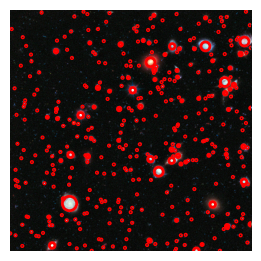

In [8]:
# Example taken from
# https://scikit-image.org/docs/stable/auto_examples/features_detection/plot_blob.html

image = data.hubble_deep_field()[0:500, 0:500]
image_gray = rgb2gray(image)

blobs_dog = blob_dog(image_gray, max_sigma=30, threshold=0.1)
blobs_dog[:, 2] = blobs_dog[:, 2] * sqrt(2)  # Compute radii in the 3rd column

plt.figure(figsize=(9, 3), dpi=100)
plt.imshow(image, cmap="gray")
for blob in blobs_dog:
    y, x, r = blob
    c = plt.Circle((x, y), r, color="red", linewidth=2, fill=False)
    plt.gca().add_patch(c)
plt.tight_layout()
plt.axis("off")
plt.show()

In [9]:
cv2.__version__

'4.6.0'

(660, 1066)


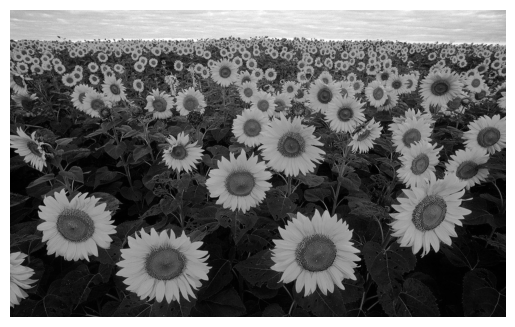

In [21]:
im = cv2.imread("media/sunflowers.jpg").astype(float).mean(2) / 255

# Display image
plt.imshow(im, cmap="gray")
plt.axis("off")
print(im.shape)

In [35]:
# Ex 8.1
def scale_spaced(im, sigma, n):
    """
    Naive implementation of the scale space pyramid with no downsampling.

    Args:
        im : input image
        sigma : standard deviation of the Gaussian kernel
        n : number of scales

    Returns:
        im_scales : list containing the scale space pyramid of the input image
        scales : list containing the scales used in the pyramid
    """
    scales = [sigma * 2**i for i in range(n)]  # ratio = 2
    im_scales = []
    for scale in scales:
        g, _ = gaussian_1D_kernel(scale)
        I = cv2.sepFilter2D(im, -1, g, g)
        im_scales.append(I)
    return im_scales, scales

im shape: (660, 1066)
scales: [2, 4, 8, 16, 32, 64, 128]


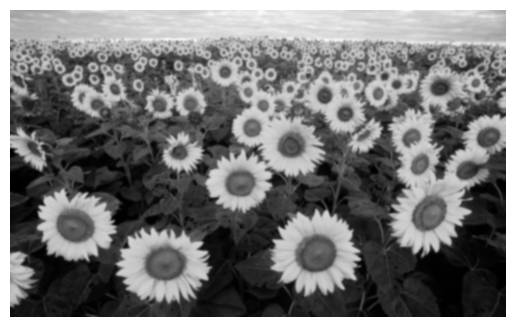

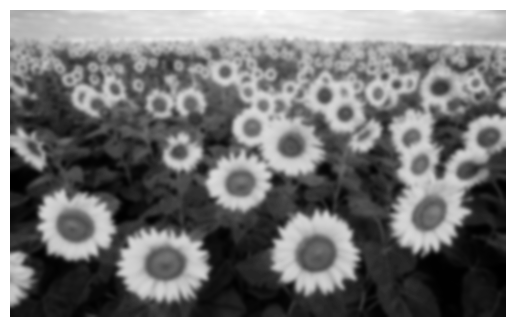

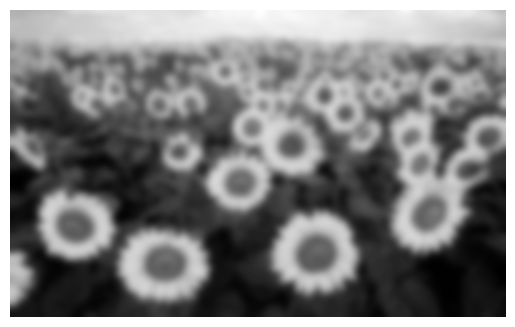

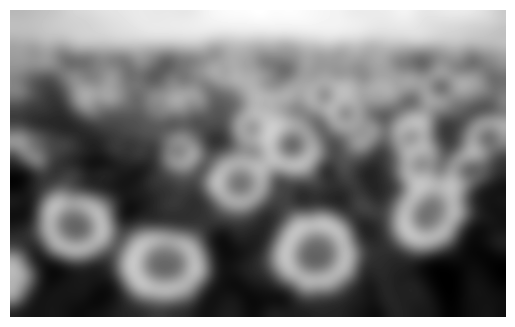

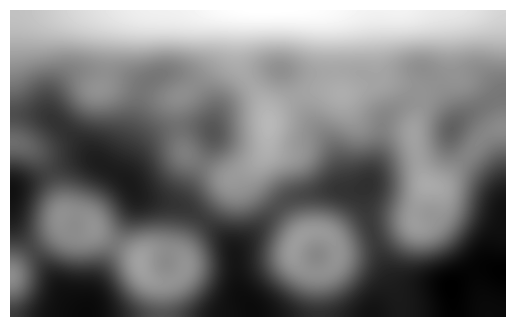

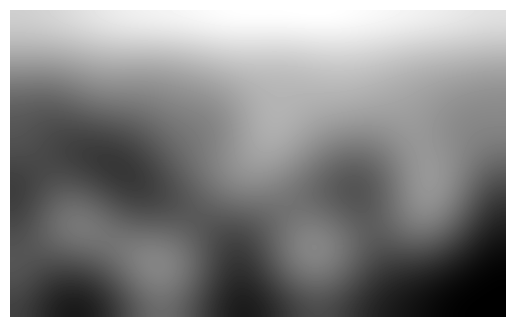

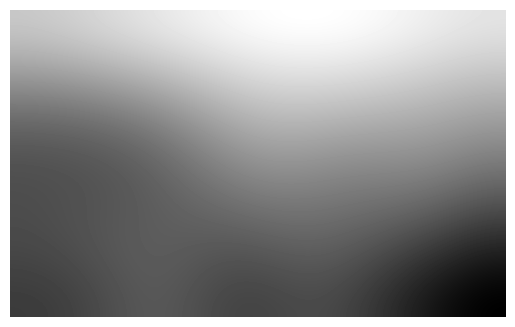

In [36]:
sigma = 2
n_scales = 7
im_scales, scales = scale_spaced(im, sigma, n_scales)

# Check images in pyramid are exactly the same as the original image
print(f"im shape: {im_scales[0].shape}")
print(f"scales: {scales}")

# Visualize images to check for progressive blur
for i, im_scale in enumerate(im_scales):
    plt.imshow(im_scale, cmap="gray")
    plt.axis("off")
    plt.show()
plt.show()

In [34]:
# Ex 8.2
def difference_of_gaussians(im, sigma, n):
    """
    Implementation of the difference of Gaussians.

    Args:
        im : input image
        sigma : standard deviation of the Gaussian kernel
        n : number of scales

    Returns:
        DoG : list of scale space DoGs of im
        scales : list containing the scales used in the pyramid
    """
    im_scales, scales = scale_spaced(im, sigma, n)
    DoG = []
    for i in range(1, n):
        diff = im_scales[i] - im_scales[i - 1]
        DoG.append(diff)
    return DoG, scales

In [38]:
sigma = 2
n_scales = 7
DoG, scales = difference_of_gaussians(im, sigma, n_scales)

# Check images in pyramid are exactly the same as the original image
print(f"No. of DoG images: {len(DoG)}")
print(f"im shape: {DoG[0].shape}")
print(DoG)

No. of DoG images: 6
im shape: (660, 1066)
[array([[ 9.04167078e-03,  9.08446849e-03,  9.24900400e-03, ...,
        -5.57296502e-03, -4.27025192e-03, -3.74322458e-03],
       [ 6.63329446e-03,  6.64860464e-03,  6.73101605e-03, ...,
        -2.68366526e-03, -1.54242063e-03, -1.09105104e-03],
       [ 9.10935309e-04,  8.33196291e-04,  6.46835508e-04, ...,
         4.39699703e-03,  5.09609788e-03,  5.34430650e-03],
       ...,
       [-5.44824066e-03, -3.91431234e-03,  6.20363781e-04, ...,
        -3.06309456e-04, -8.52333304e-04, -1.03566442e-03],
       [-5.66548192e-03, -3.94739714e-03,  1.10685954e-03, ...,
        -1.72099401e-04, -8.05230711e-04, -1.03307306e-03],
       [-5.71236696e-03, -3.92000161e-03,  1.33913230e-03, ...,
        -9.26837921e-05, -7.55716602e-04, -1.00002267e-03]]), array([[-0.00498512, -0.00486004, -0.00448018, ...,  0.02445841,
         0.02466933,  0.02474277],
       [-0.00521355, -0.00509227, -0.00472327, ...,  0.02459803,
         0.02480342,  0.02487497]

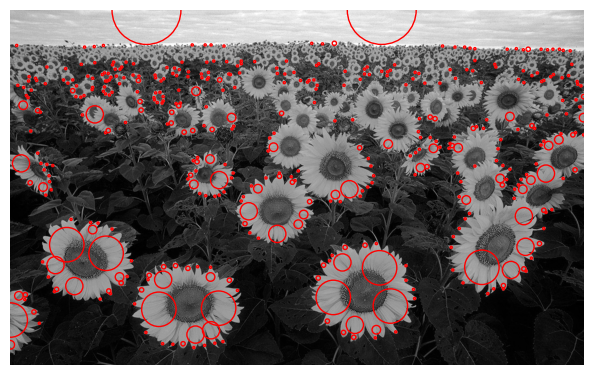

In [29]:
# Using skimage.feature.blob_dog to detect blobs
blobs_dog = blob_dog(
    im, min_sigma=2, max_sigma=128, sigma_ratio=2, threshold=0.1
)

plt.figure()
plt.imshow(im, cmap="gray")
for blob in blobs_dog:
    y, x, r = blob
    c = plt.Circle((x, y), r, color="red", linewidth=1, fill=False)
    plt.gca().add_patch(c)
plt.tight_layout()
plt.axis("off")
plt.show()

In [41]:
# Ex 8.3
def detect_blobs(im, sigma, n, tau):
    """
    Implementation of the blob detector.

    Args:
        im : input image
        sigma : standard deviation of the Gaussian kernel
        n : number of scales
        tau : threshold for blob detection

    Returns:
        blobs : list of detected blobs in the format (x, y, scale)
    """
    DoG, scales = difference_of_gaussians(im, sigma, n)

    # Obtain max value in a 3x3 neighborhood of each pixel in DoG
    MaxDoG = [cv2.dilate(dog, np.ones((3, 3))) for dog in DoG]

    # Thresholding & non-max suppression
    blobs = []
    prev_blobs = 0
    for i in range(1, len(DoG) - 1):  # for each DoG, skip first & last
        for j in range(1, im.shape[0] - 1):  # for each row
            for k in range(1, im.shape[1] - 1):  # for each column
                if (
                    DoG[i][j, k] > tau  # thresholding
                    and DoG[i][j, k] == MaxDoG[i][j, k]  # max in current DoG
                    and DoG[i][j, k]
                    > MaxDoG[i - 1][j, k]  # max in previous DoG
                    and DoG[i][j, k] > MaxDoG[i + 1][j, k]  # max in next DoG
                ):
                    blobs.append((j, k, scales[i]))
        # Calculate how many new blobs detected in this DoG
        print(f"No. of blobs detected in DoG {i}: {len(blobs)-prev_blobs}")
        prev_blobs = len(blobs)
    return blobs


sigma = 2
n_scales = 7
tau = 0.1
blobs = detect_blobs(im, sigma, n_scales, tau)
print(f"Total no. of blobs detected: {len(blobs)}")

No. of blobs detected in DoG 1: 185
No. of blobs detected in DoG 2: 88
No. of blobs detected in DoG 3: 26
No. of blobs detected in DoG 4: 9
Total no. of blobs detected: 308


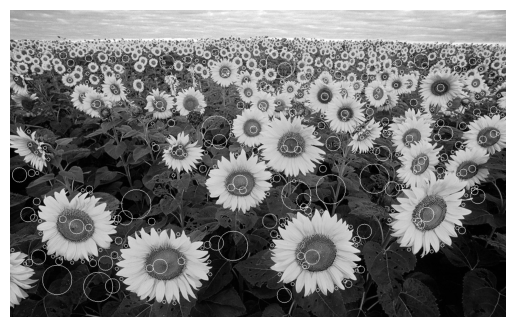

In [19]:
def visualize_blobs(blobs, im):
    im_circle = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    for x, y, scale in blobs:
        im_circle = cv2.circle(
            im_circle, (y, x), radius=int(scale), color=(255, 255), thickness=1
        )
    plt.axis("off")
    plt.imshow(im_circle, cmap="gray")
    plt.show()


im = cv2.imread("media/sunflowers.jpg")
visualize_blobs(blobs, im)

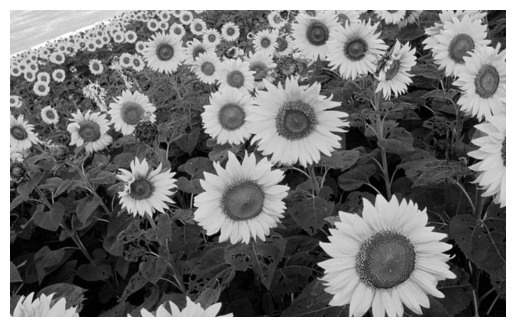

In [42]:
# Ex 8.4
def transform_im(im, theta, s):
    """
    Rotate an image by theta degrees and scale by s.

    Args:
        im : input image
        theta : angle of rotation
        s : scaling factor

    Returns:
        r_im : rotated and scaled image
    """
    rows, cols = im.shape
    M = cv2.getRotationMatrix2D((cols / 2, rows / 2), theta, s)
    r_im = cv2.warpAffine(im, M, (cols, rows))
    return r_im


r_im = transform_im(im, 20, 1.5)
plt.imshow(r_im, cmap="gray")
plt.axis("off")
plt.show()

In [44]:
# Ex 8.5
# Use SIFT detector to detect features in both original and transformed image.

# Read images as uint8
im_int = cv2.imread("media/sunflowers.jpg").mean(2).astype(np.uint8)
r_im_int = transform_im(im_int, 20, 1.5)

# SIFT detector
sift = cv2.SIFT_create()
kp1 = sift.detect(im_int, None)
kp2 = sift.detect(r_im_int, None)

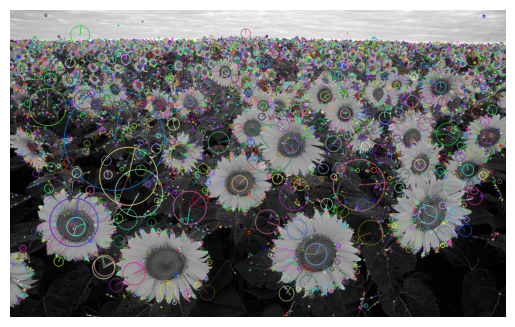

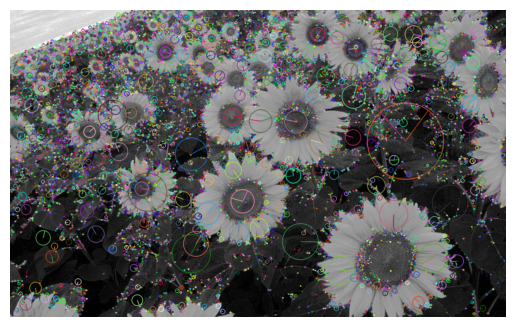

In [45]:
# Marking the keypoint on the image using circles
img = cv2.drawKeypoints(
    im_int, kp1, im_int, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
)

r_img = cv2.drawKeypoints(
    r_im_int, kp2, r_im_int, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
)

# Plot features in both images.
plt.imshow(img)
plt.axis("off")
plt.show()
plt.imshow(r_img)
plt.axis("off")
plt.show()

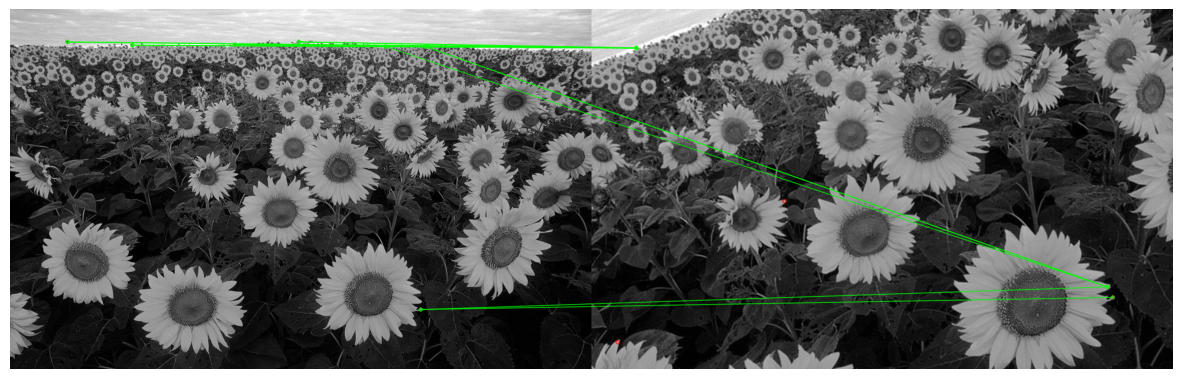

('good features',
 [[< cv2.DMatch 0000024ED44E01F0>],
  [< cv2.DMatch 0000024ED44E0250>],
  [< cv2.DMatch 0000024ED44A8AB0>]])

In [48]:
def BFMatching(img1, img2, plot=False):
    """
    Modified from https://www.geeksforgeeks.org/python-opencv-bfmatcher-function/
    """
    # Find the keypoints and descriptors
    n_feats = 10
    sift = cv2.SIFT_create(n_feats)
    # sift = cv2.ORB_create(n_feats)
    kpnt1, des1 = sift.detectAndCompute(img1, None)
    kpnt2, des2 = sift.detectAndCompute(img2, None)

    # BFMatcher with default parameters
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1, des2, k=2)

    # Apply ratio test
    good = []
    matched_image = cv2.drawMatchesKnn(
        img1,
        kpnt1,
        img2,
        kpnt2,
        matches,
        None,
        matchColor=(0, 255, 0),
        matchesMask=None,
        singlePointColor=(255, 0, 0),
        flags=0,
    )

    # Creating a criteria for the good matches
    for m, n in matches:
        if m.distance < 0.8 * n.distance:
            good.append([m])

    # Display matched image
    if plot:
        mpl.rcParams["figure.figsize"] = [15, 10]
        plt.imshow(matched_image)
        plt.axis("off")
        plt.show()
        mpl.rcParams["figure.figsize"] = [8, 6]

    return ("good features", good)  # returning ggod features


BFMatching(im, r_im, plot=True)
# This doesnt look correct